In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip

--2022-03-22 22:57:58--  https://archive.ics.uci.edu/ml/machine-learning-databases/00357/occupancy_data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 335713 (328K) [application/x-httpd-php]
Saving to: ‘occupancy_data.zip.4’

occupancy_data.zip. 100%[===================>] 327.84K   445KB/s    in 0.7s    

2022-03-22 22:58:00 (445 KB/s) - ‘occupancy_data.zip.4’ saved [335713/335713]



In [ ]:
!unzip occupancy_data.zip

Archive:  occupancy_data.zip
replace datatest.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Input, Bidirectional
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
train_df = pd.read_csv('datatraining.txt')

In [ ]:
train_df.head(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
1,2015-02-04 17:51:00,23.180,27.2720,426.0,721.250000,0.004793,1
2,2015-02-04 17:51:59,23.150,27.2675,429.5,714.000000,0.004783,1
3,2015-02-04 17:53:00,23.150,27.2450,426.0,713.500000,0.004779,1
4,2015-02-04 17:54:00,23.150,27.2000,426.0,708.250000,0.004772,1
5,2015-02-04 17:55:00,23.100,27.2000,426.0,704.500000,0.004757,1
6,2015-02-04 17:55:59,23.100,27.2000,419.0,701.000000,0.004757,1
7,2015-02-04 17:57:00,23.100,27.2000,419.0,701.666667,0.004757,1
8,2015-02-04 17:57:59,23.100,27.2000,419.0,699.000000,0.004757,1
9,2015-02-04 17:58:59,23.100,27.2000,419.0,689.333333,0.004757,1
10,2015-02-04 18:00:00,23.075,27.1750,419.0,688.000000,0.004745,1


In [ ]:
test_df = pd.read_csv('datatest.txt')

In [ ]:
test_df.head(10)

,date,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
140,2015-02-02 14:19:00,23.7000,26.272,585.200000,749.200000,0.004764,1
141,2015-02-02 14:19:59,23.7180,26.290,578.400000,760.400000,0.004773,1
142,2015-02-02 14:21:00,23.7300,26.230,572.666667,769.666667,0.004765,1
143,2015-02-02 14:22:00,23.7225,26.125,493.750000,774.750000,0.004744,1
144,2015-02-02 14:23:00,23.7540,26.200,488.600000,779.000000,0.004767,1
145,2015-02-02 14:23:59,23.7600,26.260,568.666667,790.000000,0.004779,1
146,2015-02-02 14:25:00,23.7300,26.290,536.333333,798.000000,0.004776,1
147,2015-02-02 14:25:59,23.7540,26.290,509.000000,797.000000,0.004783,1
148,2015-02-02 14:26:59,23.7540,26.350,476.000000,803.200000,0.004794,1
149,2015-02-02 14:28:00,23.7360,26.390,510.000000,809.000000,0.004796,1


In [ ]:
input_features = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
target_features = ['CO2', 'Light']
n_steps, n_preds = 16, 4

In [ ]:
def generate_sequence(X, y, n_steps, n_preds):
  assert len(X) == len(y)

  X_seq = []
  y_seq = []
  i = n_steps

  while i < len(X) - n_preds:
    X_seq.append(X[i-n_steps: i])
    y_seq.append(y[i: i+n_preds].reshape(-1))
    i += 1

  return np.array(X_seq), np.array(y_seq)

In [ ]:
X_train, y_train = generate_sequence(train_df[input_features].to_numpy(), train_df[target_features].to_numpy(), n_steps, n_preds)
X_test, y_test   = generate_sequence(test_df[input_features].to_numpy(),test_df[target_features].to_numpy(), n_steps, n_preds)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1]

In [ ]:
normalizer = tf.keras.layers.experimental.preprocessing.Normalization()
normalizer.adapt(X_train)

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.2, min_lr=1e-6)
es = tf.keras.callbacks.EarlyStopping(patience=15)

n_epochs = 100

In [ ]:
#### simple 1 layer
model1 = Sequential()
model1.add(Input(input_shape))
model1.add(normalizer)
model1.add(SimpleRNN(32, activation='tanh', return_sequences = False))
model1.add(Dense(32, activation='relu'))
model1.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model1.compile(optimizer=optim, loss='mse', metrics=['mae'])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                1216      
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                                 
Total params: 2,547
Trainable params: 2,536
Non-trainable params: 11
_________________________________________________________________


In [ ]:
history = model1.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 6s 21ms/step - loss: 259873.9219 - mae: 364.3157 - val_loss: 134874.7812 - val_mae: 268.7358 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 4s 19ms/step - loss: 205733.5000 - mae: 322.7253 - val_loss: 86381.4609 - val_mae: 226.0735 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 4s 19ms/step - loss: 135725.0312 - mae: 248.8304 - val_loss: 45116.7188 - val_mae: 164.2506 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 4s 19ms/step - loss: 85660.1719 - mae: 175.5460 - val_loss: 23436.3418 - val_mae: 107.3585 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 4s 19ms/step - loss: 59800.6055 - mae: 137.6366 - val_loss: 15646.5029 - val_mae: 75.0132 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 4s 19ms/step - loss: 47113.3516 - mae: 121.5202 - val_loss: 16520.6660 - val_mae: 90.1224 - lr: 0.0010
Epoch 7/100
229/229 [=======================

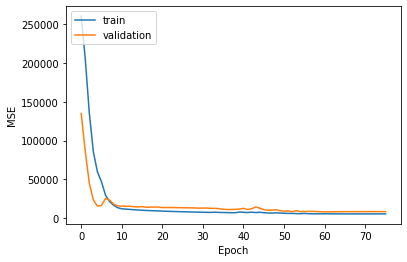

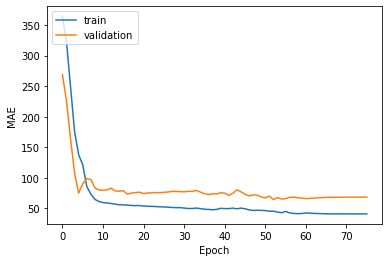

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### simple 2 layer
model2 = Sequential()
model2.add(Input(input_shape))
model2.add(normalizer)
model2.add(SimpleRNN(32, activation='tanh', return_sequences = True))
model2.add(SimpleRNN(32, activation='tanh', return_sequences = False))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model2.compile(optimizer=optim, loss='mse', metrics=['mae'])
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16, 32)            1216      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 8)                 264       
                                                                 
Total params: 4,627
Trainable params: 4,616
Non-trainable params: 11
___________________________________________________

In [ ]:
history = model2.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 11s 40ms/step - loss: 258245.8906 - mae: 363.0830 - val_loss: 127666.7578 - val_mae: 267.8364 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 9s 39ms/step - loss: 201575.0156 - mae: 321.2614 - val_loss: 113241.3516 - val_mae: 273.1817 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 9s 38ms/step - loss: 146781.3906 - mae: 250.6609 - val_loss: 78152.8594 - val_mae: 258.0268 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 9s 39ms/step - loss: 104156.6328 - mae: 180.4320 - val_loss: 70302.7891 - val_mae: 226.5588 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 9s 39ms/step - loss: 77940.3359 - mae: 154.6274 - val_loss: 78142.4688 - val_mae: 236.9847 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 9s 39ms/step - loss: 58930.6641 - mae: 142.5847 - val_loss: 75953.9297 - val_mae: 249.5132 - lr: 0.0010
Epoch 7/100
229/229 [==================

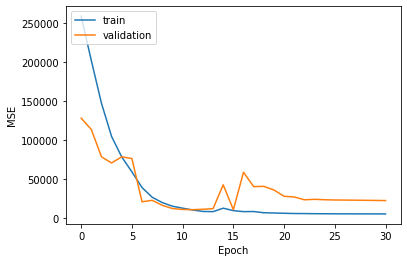

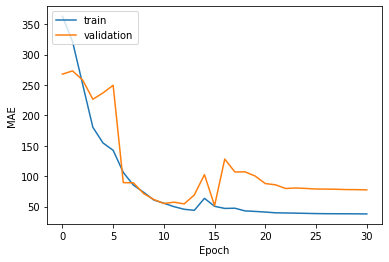

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### simple 3 layers
model3 = Sequential()
model3.add(Input(input_shape))
model3.add(normalizer)
model3.add(SimpleRNN(32, activation='tanh', return_sequences = True))
model3.add(SimpleRNN(32, activation='tanh', return_sequences = True))
model3.add(SimpleRNN(32, activation='tanh', return_sequences = False))
model3.add(Dense(32, activation='relu'))
model3.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model3.compile(optimizer=optim, loss='mse', metrics=['mae'])
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 16, 32)            1216      
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 16, 32)            2080      
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1056      
                                                                 
 dense_5 (Dense)             (None, 8)                 264       
                                                      

In [ ]:
history = model3.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 17s 64ms/step - loss: 257939.7031 - mae: 363.8557 - val_loss: 134251.9844 - val_mae: 274.2417 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 14s 63ms/step - loss: 199464.9844 - mae: 325.9099 - val_loss: 85633.0703 - val_mae: 241.7195 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 14s 62ms/step - loss: 132818.5469 - mae: 256.4524 - val_loss: 40300.3672 - val_mae: 167.6488 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 14s 62ms/step - loss: 74290.2812 - mae: 164.9358 - val_loss: 17006.4668 - val_mae: 87.0216 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 14s 60ms/step - loss: 46147.4375 - mae: 113.6509 - val_loss: 18838.7754 - val_mae: 80.9934 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 14s 60ms/step - loss: 37646.6289 - mae: 97.0184 - val_loss: 22000.4297 - val_mae: 84.3796 - lr: 0.0010
Epoch 7/100
229/229 [===================

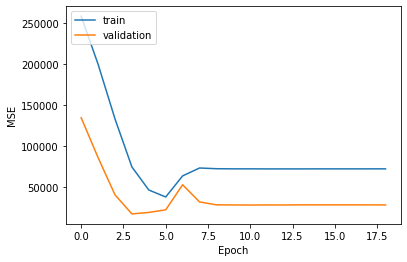

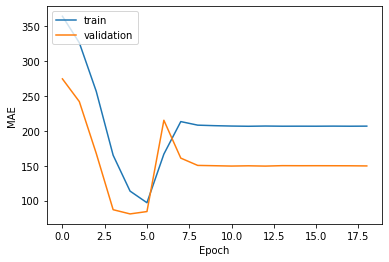

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### lstm 1 layer
model4 = Sequential()
model4.add(Input(input_shape))
model4.add(normalizer)
model4.add(LSTM(32, activation='tanh', return_sequences = False))
model4.add(Dense(32, activation='relu'))
model4.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model4.compile(optimizer=optim, loss='mse', metrics=['mae'])
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 lstm (LSTM)                 (None, 32)                4864      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dense_7 (Dense)             (None, 8)                 264       
                                                                 
Total params: 6,195
Trainable params: 6,184
Non-trainable params: 11
_________________________________________________________________


In [ ]:
history = model4.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 6s 9ms/step - loss: 249969.6094 - mae: 358.7001 - val_loss: 107062.3750 - val_mae: 261.3678 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 2s 7ms/step - loss: 152275.6406 - mae: 281.9434 - val_loss: 38636.3398 - val_mae: 169.3448 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 2s 7ms/step - loss: 87447.3203 - mae: 190.3528 - val_loss: 20604.8770 - val_mae: 125.3977 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 2s 7ms/step - loss: 58429.8945 - mae: 150.1028 - val_loss: 15353.9854 - val_mae: 105.2394 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 2s 7ms/step - loss: 32548.2090 - mae: 111.8925 - val_loss: 12921.0850 - val_mae: 88.8296 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 2s 7ms/step - loss: 18908.4473 - mae: 80.6143 - val_loss: 10435.2744 - val_mae: 72.2704 - lr: 0.0010
Epoch 7/100
229/229 [==============================]

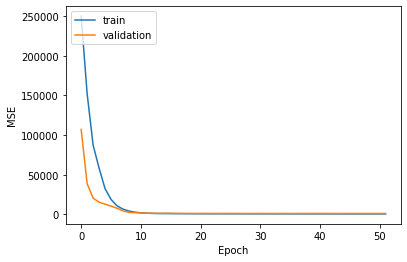

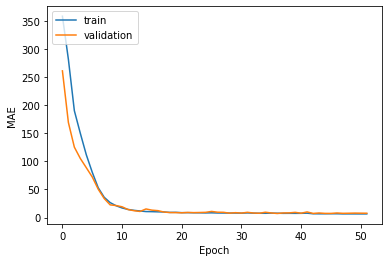

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### lstm 2 layer
model5 = Sequential()
model5.add(Input(input_shape))
model5.add(normalizer)
model5.add(LSTM(32, activation='tanh', return_sequences = True))
model5.add(LSTM(32, activation='tanh', return_sequences = False))
model5.add(Dense(32, activation='relu'))
model5.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model5.compile(optimizer=optim, loss='mse', metrics=['mae'])
model5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 16, 32)            4864      
                                                                 
 lstm_2 (LSTM)               (None, 32)                8320      
                                                                 
 dense_8 (Dense)             (None, 32)                1056      
                                                                 
 dense_9 (Dense)             (None, 8)                 264       
                                                                 
Total params: 14,515
Trainable params: 14,504
Non-trainable params: 11
_________________________________________________

In [ ]:
history = model5.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 8s 15ms/step - loss: 250879.4375 - mae: 360.1960 - val_loss: 112156.7891 - val_mae: 266.3392 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 3s 11ms/step - loss: 162527.2188 - mae: 293.9257 - val_loss: 45569.4922 - val_mae: 185.3581 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 3s 11ms/step - loss: 91414.3672 - mae: 192.2773 - val_loss: 22649.3867 - val_mae: 125.0258 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 3s 11ms/step - loss: 50596.6797 - mae: 138.3694 - val_loss: 13601.7949 - val_mae: 98.1383 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 3s 11ms/step - loss: 26041.1777 - mae: 94.1195 - val_loss: 8386.8525 - val_mae: 68.7828 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 3s 11ms/step - loss: 13939.4395 - mae: 54.9175 - val_loss: 4696.5503 - val_mae: 42.1326 - lr: 0.0010
Epoch 7/100
229/229 [=============================

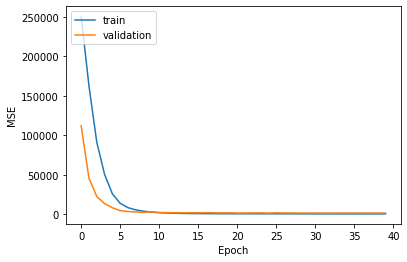

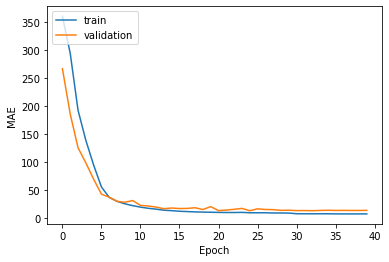

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### lstm 3 layer
model6 = Sequential()
model6.add(Input(input_shape))
model6.add(normalizer)
model6.add(LSTM(32, activation='tanh', return_sequences = True))
model6.add(LSTM(32, activation='tanh', return_sequences = True))
model6.add(LSTM(32, activation='tanh', return_sequences = False))
model6.add(Dense(32, activation='relu'))
model6.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model6.compile(optimizer=optim, loss='mse', metrics=['mae'])
model6.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 lstm_3 (LSTM)               (None, 16, 32)            4864      
                                                                 
 lstm_4 (LSTM)               (None, 16, 32)            8320      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_10 (Dense)            (None, 32)                1056      
                                                                 
 dense_11 (Dense)            (None, 8)                 264       
                                                      

In [ ]:
history = model6.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 10s 22ms/step - loss: 259422.2812 - mae: 363.7775 - val_loss: 133722.8906 - val_mae: 269.1364 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 4s 16ms/step - loss: 205995.6562 - mae: 319.2544 - val_loss: 89800.4219 - val_mae: 263.8625 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 4s 16ms/step - loss: 136303.4688 - mae: 242.5274 - val_loss: 50287.1523 - val_mae: 176.4073 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 4s 17ms/step - loss: 82385.3594 - mae: 162.5822 - val_loss: 23998.8359 - val_mae: 99.6489 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 4s 16ms/step - loss: 47357.3906 - mae: 101.8312 - val_loss: 14493.1582 - val_mae: 63.9148 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 4s 16ms/step - loss: 27365.5020 - mae: 65.5199 - val_loss: 11113.6484 - val_mae: 50.2674 - lr: 0.0010
Epoch 7/100
229/229 [========================

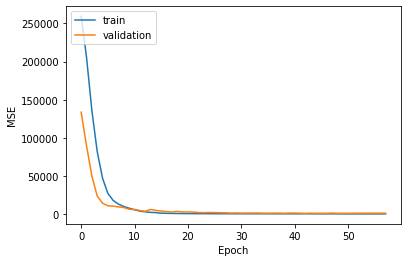

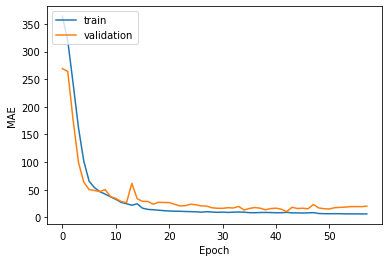

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### bi-lstm 1 layer
model7 = Sequential()
model7.add(Input(input_shape))
model7.add(normalizer)
model7.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = False)))
model7.add(Dense(32, activation='relu'))
model7.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model7.compile(optimizer=optim, loss='mse', metrics=['mae'])
model7.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 bidirectional (Bidirectiona  (None, 64)               9728      
 l)                                                              
                                                                 
 dense_12 (Dense)            (None, 32)                2080      
                                                                 
 dense_13 (Dense)            (None, 8)                 264       
                                                                 
Total params: 12,083
Trainable params: 12,072
Non-trainable params: 11
_________________________________________________________________


In [ ]:
history = model7.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 7s 15ms/step - loss: 229805.6875 - mae: 344.4065 - val_loss: 71623.8203 - val_mae: 230.6377 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 2s 11ms/step - loss: 104528.5000 - mae: 215.7192 - val_loss: 20518.5918 - val_mae: 122.5070 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 2s 11ms/step - loss: 57477.1289 - mae: 153.5479 - val_loss: 15956.7217 - val_mae: 111.0983 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 2s 11ms/step - loss: 26990.6953 - mae: 104.3147 - val_loss: 13334.4473 - val_mae: 99.4680 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 2s 11ms/step - loss: 16182.5068 - mae: 79.1608 - val_loss: 10571.1836 - val_mae: 82.1131 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 2s 11ms/step - loss: 8562.7383 - mae: 47.7517 - val_loss: 5829.6592 - val_mae: 45.7191 - lr: 0.0010
Epoch 7/100
229/229 [==============================

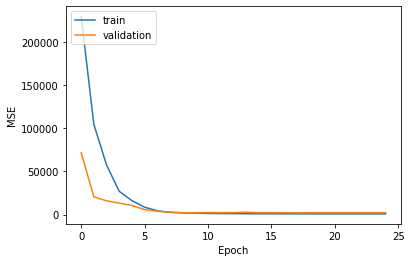

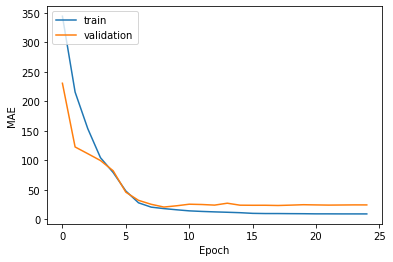

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### bi-lstm 2 layer
model8 = Sequential()
model8.add(Input(input_shape))
model8.add(normalizer)
model8.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = True)))

model8.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = False)))
model8.add(Dense(32, activation='relu'))
model8.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model8.compile(optimizer=optim, loss='mse', metrics=['mae'])
model8.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 16, 64)           9728      
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_14 (Dense)            (None, 32)                2080      
                                                                 
 dense_15 (Dense)            (None, 8)                 264       
                                                      

In [ ]:
history = model8.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 13s 28ms/step - loss: 231688.5938 - mae: 347.3055 - val_loss: 79649.5469 - val_mae: 240.7671 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 5s 21ms/step - loss: 113243.0000 - mae: 227.4581 - val_loss: 21461.5625 - val_mae: 118.3377 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 5s 21ms/step - loss: 74885.1250 - mae: 196.2563 - val_loss: 19256.2715 - val_mae: 126.2393 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 5s 21ms/step - loss: 43445.7344 - mae: 129.9452 - val_loss: 13917.4512 - val_mae: 98.5590 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 5s 21ms/step - loss: 22529.7578 - mae: 97.9444 - val_loss: 10999.3857 - val_mae: 87.2294 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 5s 21ms/step - loss: 13503.6768 - mae: 72.0897 - val_loss: 6657.6040 - val_mae: 63.4359 - lr: 0.0010
Epoch 7/100
229/229 [============================

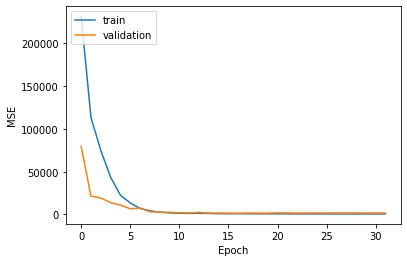

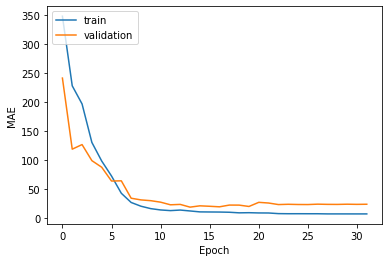

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
#### bi-lstm 3 layer
model9 = Sequential()
model9.add(Input(input_shape))
model9.add(normalizer)
model9.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = True)))
model9.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = True)))

model9.add(Bidirectional(LSTM(32, activation='tanh', return_sequences = False)))
model9.add(Dense(32, activation='relu'))
model9.add(Dense(output_shape, activation='linear'))

optim=tf.keras.optimizers.Adam(0.001)
model9.compile(optimizer=optim, loss='mse', metrics=['mae'])
model9.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 16, 5)            11        
 n)                                                              
                                                                 
 bidirectional_3 (Bidirectio  (None, 16, 64)           9728      
 nal)                                                            
                                                                 
 bidirectional_4 (Bidirectio  (None, 16, 64)           24832     
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_16 (Dense)            (None, 32)               

In [ ]:
history = model9.fit(X_train, y_train, validation_split=0.1, epochs=n_epochs, verbose=1, callbacks=[reduce_lr, es])

Epoch 1/100
229/229 [==============================] - 20s 43ms/step - loss: 240711.2031 - mae: 352.2440 - val_loss: 97049.9062 - val_mae: 251.3832 - lr: 0.0010
Epoch 2/100
229/229 [==============================] - 7s 32ms/step - loss: 141318.9531 - mae: 267.3554 - val_loss: 33245.2930 - val_mae: 152.2612 - lr: 0.0010
Epoch 3/100
229/229 [==============================] - 7s 32ms/step - loss: 83625.4297 - mae: 187.6369 - val_loss: 20793.2910 - val_mae: 128.5652 - lr: 0.0010
Epoch 4/100
229/229 [==============================] - 7s 32ms/step - loss: 68037.7578 - mae: 179.2540 - val_loss: 13469.5527 - val_mae: 95.9754 - lr: 0.0010
Epoch 5/100
229/229 [==============================] - 7s 32ms/step - loss: 30903.3418 - mae: 98.6269 - val_loss: 10770.0479 - val_mae: 73.9170 - lr: 0.0010
Epoch 6/100
229/229 [==============================] - 8s 33ms/step - loss: 13424.8486 - mae: 58.0195 - val_loss: 8070.6777 - val_mae: 48.2659 - lr: 0.0010
Epoch 7/100
229/229 [============================

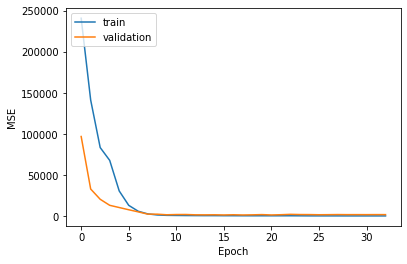

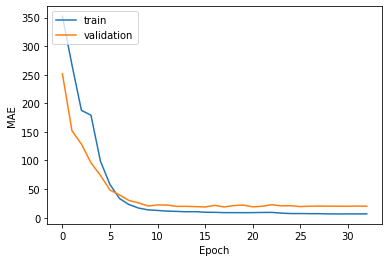

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()